In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column as fc

In [2]:
# Determine CSV, label, and key columns
# Create list of string column headers, make sure order matches.
CSV_COLUMNS = ["weight_pounds",
               "is_male",
               "mother_age",
               "plurality",
               "gestation_weeks",
               "mother_race"]

# Add string name for label column
LABEL_COLUMN = "weight_pounds"

# Set default values for each CSV column as a list of lists.
# Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0], ["null"]]

In [3]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.
    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label


def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    """Loads dataset using the tf.data API from CSV files.
    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: tf.estimator.ModeKeys to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS)

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset#.shuffle(buffer_size=1000)#.repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [4]:
tf.random.set_seed(33)

TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 1000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 5  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 1000


trainds = load_dataset(
    pattern="./data/babyweight_train*",
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

evalds = load_dataset(
    pattern="./data/babyweight_eval*",
    batch_size=1000,
    mode=tf.estimator.ModeKeys.EVAL).take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

Next, we build the model just as before.

In [5]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in ["mother_age", "gestation_weeks"]}

    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in ["is_male", "plurality", "mother_race"]})

    return inputs

In [6]:
def categorical_fc(name, values):
    cat_column = fc.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return fc.indicator_column(categorical_column=cat_column)


def create_feature_columns():
    feature_columns = {
        colname : fc.numeric_column(key=colname)
           for colname in ["mother_age", "gestation_weeks"]
    }

    feature_columns["is_male"] = categorical_fc(
        "is_male", ["True", "False", "Unknown"])
    feature_columns["plurality"] = categorical_fc(
        "plurality", ["Single(1)", "Twins(2)", "Triplets(3)",
                      "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])
    feature_columns["mother_race"] = fc.indicator_column(
        fc.categorical_column_with_hash_bucket(
            "mother_race", hash_bucket_size=17, dtype=tf.dtypes.string))
    
    feature_columns["gender_x_plurality"] = fc.embedding_column(
        fc.crossed_column(["is_male", "plurality"], hash_bucket_size=18),
        dimension=2)

    return feature_columns

In [7]:
feature_columns = create_feature_columns()
print("Feature column keys: \n{}\n".format(list(feature_columns.keys())))
print("Feature column values: \n{}\n".format(list(feature_columns.values())))

Feature column keys: 
['mother_age', 'gestation_weeks', 'is_male', 'plurality', 'mother_race', 'gender_x_plurality']

Feature column values: 
[NumericColumn(key='mother_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='gestation_weeks', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='is_male', vocabulary_list=('True', 'False', 'Unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='plurality', vocabulary_list=('Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)', 'Multiple(2+)'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=HashedCategoricalColumn(key='mother_race', hash_bucket_size=17, dtype=tf.string)), EmbeddingColumn(categorical_column=CrossedColumn(keys=('is_male', 'plurality'), hash_bucket_si

In [8]:
def get_model_outputs(inputs):
    # Create two hidden layers of [64, 32] just in like the BQML DNN
    h1 = layers.Dense(64, activation="relu", name="h1")(inputs)
    h2 = layers.Dense(32, activation="relu", name="h2")(h1)

    # Final output is a linear activation because this is regression
    output = layers.Dense(units=1, activation="linear", name="weight")(h2)

    return output

In [9]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

In [10]:
def build_dnn_model():
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers()

    # Create feature columns
    feature_columns = create_feature_columns()

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
________________________________________________________________________________

## Overfit on a batch

We can inspect our `tf.data` input pipeline. The code below will take a single batch of `trainds` and print the features and labels in that batch. Note that each time you execute the cell below you get another batch of data. This is becuase the Dataset takes a new batch each time. 

In [11]:
for feature_batch, label_batch in trainds.take(1):
    print("'babyweight': {}".format(label_batch))
    print("features:")
    for key, value in feature_batch.items():
      print("  {!r:20s}: {}".format(key, value))

'babyweight': [ 7.572879   6.3052206  8.873606   5.626197   6.812284  10.24929
  8.562755   5.3131404  9.748841   7.438397   8.2056055  6.823307
  6.68662    6.9996767  8.501025   6.68662    7.561856   6.062712
  7.627994   8.249698   6.9996767  9.499719   7.804364   6.83433
  8.126239   7.312733   4.5635686  9.590109   6.790238   7.1253405
  5.5799     8.501025 ]
features:
  'is_male'           : [b'True' b'False' b'True' b'False' b'True' b'True' b'True' b'True'
 b'False' b'False' b'True' b'False' b'True' b'True' b'False' b'False'
 b'False' b'True' b'True' b'False' b'False' b'True' b'True' b'True'
 b'True' b'False' b'True' b'False' b'False' b'True' b'False' b'True']
  'mother_age'        : [18. 16. 18. 17. 16. 18. 17. 17. 15. 17. 15. 17. 17. 17. 15. 14. 16. 17.
 15. 17. 14. 17. 17. 14. 16. 17. 17. 17. 18. 17. 16. 17.]
  'plurality'         : [b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)'
 b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)'
 b'Single(1)'

To train on a single batch, we'll pull one batch from the `tf.data` pipeline and create a new Dataset. 

In [12]:
single_batch = tf.data.Dataset.from_tensor_slices((feature_batch, label_batch)).batch(TRAIN_BATCH_SIZE)

As before we can inspect the elements of this dataset. Note now, however, that if you execute this cell more than once, you still get the same batch of data. 
This is what we want to train on to overfit on a batch. 

In [13]:
for dict_slice in single_batch:
    print(dict_slice)

(OrderedDict([('is_male', <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'True', b'False', b'True', b'False', b'True', b'True', b'True',
       b'True', b'False', b'False', b'True', b'False', b'True', b'True',
       b'False', b'False', b'False', b'True', b'True', b'False', b'False',
       b'True', b'True', b'True', b'True', b'False', b'True', b'False',
       b'False', b'True', b'False', b'True'], dtype=object)>), ('mother_age', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([18., 16., 18., 17., 16., 18., 17., 17., 15., 17., 15., 17., 17.,
       17., 15., 14., 16., 17., 15., 17., 14., 17., 17., 14., 16., 17.,
       17., 17., 18., 17., 16., 17.], dtype=float32)>), ('plurality', <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Single(1)', b'Single(1)', b'Single(1)', b'Single(1)',
       b'Single(1)', b'Single(1)', b'Single(1)', b'Single(1)',
       b'Single(1)', b'Single(1)', b'Single(1)', b'Single(1)',
       b'Single(1)', b'Single(1)', b'Single(1)', b'Single(1)',

Now we'll train on that single batch. We'll use the full validation set for evaluation. 

In [14]:
evalds = load_dataset(
    pattern="./data/babyweight_eval*",
    batch_size=1000,
    mode=tf.estimator.ModeKeys.EVAL).take(50)

history = model.fit(single_batch,
                    validation_data=evalds,
                    epochs=20,
                    verbose=0)

In [15]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

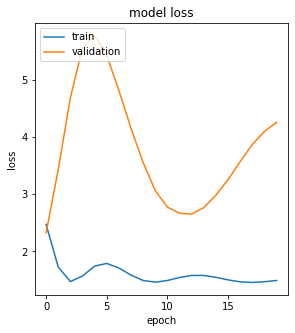

In [17]:
plot_curves(history, ['loss'])

The train and validation loss curves show behavior typical of overfitting. The gap between training and validation loss increases with successive epochs. 

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License